# The Battle of neighborhoods(Capstone Project) - Week 1 by Gaurav Singh

Introduction : Business Problem

The aim of this project is to find a safe and secure location for opening of commercial establishments in Vancouver city, Canada. 
Specifically, this report will be targeted to stakeholders interested in opening any business places like restaurants(say authentic indian food), grocery store in Vancouver City, Canada.

(1) The first task would be to choose the safest and secure borough by analysing crime data for opening a restaurants(say and or grocery store and the, short listing a neighbourhood where restaurants and or grocery stores are not amongst the most commom venues, and yet as close to the city as possible.

(2) to finalize the best location/neighbourhood as per our needs, we will make use of our data science tools to analyse data and focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood where restuarants and or grocery stores are not amongst the most common venue, can be selected.

Data :
    
Based on definition of our problem, factors that will influence our decission are below:

(1) finding the safest borough based on crime statistics
(2) finding the most common venues having restaurants(having authenic indian food), grocery stores
(2) choosing the right neighbourhood within the borough

We will be using the geographical coordinates of Vancouver to plot neighbourhoods in a borough that is safe and in the city's vicinity, and finally cluster our neighborhoods and present our findings.

Following data sources will be needed to extract/generate the required information:

Part 1: Using a real world data set from Kaggle containing the Vancouver Crimes from 2003 to 2019: A dataset consisting of the crime statistics of each Neighbourhoof in Vancouver along with type of crime, recorded year, month and hour.

Part 2: Gathering additional information of the list of officially categorized boroughs in Vancouver from Wikipedia.: Borough information will be used to map the existing data where each neighbourhood can be assigned with the right borough.

Part 3: Creating a new consolidated dataset of the Neighborhoods, along with their boroughs, crime data and the respective Neighbourhood's co-ordinates.: This data will be fetched using OpenCage Geocoder to find the safest borough and explore the neighbourhood by plotting it on maps using Folium and perform exploratory data analysis.

Part 4: Creating a new consolidated dataset of the Neighborhoods, boroughs, and the most common venues and the respective Neighbourhood along with co-ordinates.: This data will be fetched using Four Square API to explore the neighbourhood venues and to apply machine learning algorithm to cluster the neighbourhoods and present the findings by plotting it on maps using Folium.

# The Battle of Neighborhoods(Capstone Project) Week 2 by Gaurav Singh

Based on above data requirements and analysis, we begin here using data science tools and different libraries to complete our requirement

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
#import folium
!pip install folium

print('Libraries imported.')

     |████████████████████████████████| 93 kB 2.1 MB/s eta 0:00:011
Libraries imported.


PART 1 : Using a real world data set from Kaggle containing the Vancouver Crimes from 2003 to 2019: A dataset consisting of the crime statistics of each Neighbourhoof in Vancouver along with type of crime, recorded year, month and hour.

In [13]:
# Reading from the CSV as kaggle data is corrupt

vnc_crime_df = pd.read_csv('https://raw.githubusercontent.com/RamanujaSVL/Coursera_Capstone/master/vancouver_crime_records_2018.csv', index_col=None)

vnc_crime_df.head()

#Dropping the not-required columns like Unmaed:0, X,Y which represents Lat, Lng data as Coordinates.

vnc_crime_df.drop(['Unnamed: 0','MINUTE', 'HUNDRED_BLOCK', 'X', 'Y'], axis = 1, inplace = True)

vnc_crime_df.columns

vnc_crime_df.columns = ['Type', 'Year','Month','Day','Hour','Neighbourhood'] # changing the columns from all capital


vnc_crime_df.head(10)


,Type,Year,Month,Day,Hour,Neighbourhood
0,Break and Enter Commercial,2018,3,2,6,West End
1,Break and Enter Commercial,2018,6,16,18,West End
2,Break and Enter Commercial,2018,12,12,0,West End
3,Break and Enter Commercial,2018,4,9,6,Central Business District
4,Break and Enter Commercial,2018,10,2,18,Central Business District
5,Break and Enter Commercial,2018,2,17,15,Central Business District
6,Break and Enter Commercial,2018,5,16,17,Hastings-Sunrise
7,Break and Enter Commercial,2018,3,2,3,West End
8,Break and Enter Commercial,2018,3,17,11,West End
9,Break and Enter Commercial,2018,6,3,2,West End


Finding distinct crimes in different neighborhoods

In [14]:
vnc_crime_df['Neighbourhood'].value_counts()


Central Business District    10857
West End                      3031
Mount Pleasant                2396
Strathcona                    1987
Kitsilano                     1802
Fairview                      1795
Renfrew-Collingwood           1762
Grandview-Woodland            1761
Kensington-Cedar Cottage      1391
Hastings-Sunrise              1270
Sunset                         967
Riley Park                     866
Marpole                        828
Victoria-Fraserview            600
Killarney                      565
Oakridge                       499
Dunbar-Southlands              474
Kerrisdale                     417
Shaughnessy                    414
West Point Grey                372
Arbutus Ridge                  311
South Cambie                   292
Stanley Park                   154
Musqueam                        17
Name: Neighbourhood, dtype: int64

PART 2: Gathering additional information about the Neighborhood from Wikipedia
As part of data set Borough which the neighborhood was part of was not categorized, so we will create a dictionary of Neighborhood and based on data in the following Wikipedia page.

In [15]:
# define the dataframe columns
column_names = ['Neighbourhood', 'Borough'] 

# instantiate the dataframe
vnc_neigh_bor = pd.DataFrame(columns=column_names)

vnc_neigh_bor['Neighbourhood'] = vnc_crime_df['Neighbourhood'].unique()

neigh_bor_dict = {'Central Business District':'Central', 'West End':'Central', 'Stanley Park':'Central', 'Victoria-Fraserview':'South Vancouver',
                  'Killarney':'South Vancouver', 'Musqueam':'South Vancouver', 'Mount Pleasant':'East Side', 'Strathcona':'East Side',
                  'Renfrew-Collingwood':'East Side', 'Grandview-Woodland':'East Side', 'Kensington-Cedar Cottage':'East Side', 'Hastings-Sunrise':'East Side',
                  'Sunset':'East Side', 'Riley Park':'East Side', 'Kitsilano':'West Side', 'Fairview':'West Side',
                  'Marpole':'West Side', 'Oakridge':'West Side', 'Dunbar-Southlands':'West Side', 'Kerrisdale':'West Side',
                  'Shaughnessy':'West Side', 'West Point Grey':'West Side', 'Arbutus Ridge':'West Side', 'South Cambie':'West Side'}

for row, neigh in zip(neigh_bor_dict, vnc_neigh_bor['Neighbourhood']):
  vnc_neigh_bor.loc[vnc_neigh_bor.Neighbourhood == row, 'Borough'] = neigh_bor_dict.get(row)

vnc_neigh_bor.dropna(inplace=True)

print("Total Neighbourhood Count",len(vnc_neigh_bor['Neighbourhood']),"Borough Count",len(vnc_neigh_bor['Borough'].unique()))

vnc_neigh_bor.head()

Total Neighbourhood Count 24 Borough Count 4


,Neighbourhood,Borough
0,West End,Central
1,Central Business District,Central
2,Hastings-Sunrise,East Side
3,Grandview-Woodland,East Side
4,Mount Pleasant,East Side


In [16]:
# Merging the crime data table to include boroughs
vnc_boroughs_crime = pd.merge(vnc_crime_df,vnc_neigh_bor, on='Neighbourhood')

vnc_boroughs_crime.head()

,Type,Year,Month,Day,Hour,Neighbourhood,Borough
0,Break and Enter Commercial,2018,3,2,6,West End,Central
1,Break and Enter Commercial,2018,6,16,18,West End,Central
2,Break and Enter Commercial,2018,12,12,0,West End,Central
3,Break and Enter Commercial,2018,3,2,3,West End,Central
4,Break and Enter Commercial,2018,3,17,11,West End,Central


In [17]:
# cleaning data by drping invalid rows
vnc_boroughs_crime.dropna(inplace=True)
vnc_boroughs_crime['Borough'].value_counts()

Central            14042
East Side          12400
West Side           7204
South Vancouver     1182
Name: Borough, dtype: int64

Methodology
Categorized the methodologysection into two parts:

Exploratory Data Analysis: Visualise the crime repots in different Vancouver boroughs to idenity the safest borough and normalise the neighborhoods of that borough. We will Use the resulting data and find 10 most common venues in each neighborhood.

Modelling: To help stakeholders choose the right neighborhood within a borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use K-Means clustering to address this problem so as to group data based on existing venues which will help in the decision making process.


Exploratory Data Analysis

In [18]:
# Pivoting the table to better understand the data by crimes per borough
vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                787                               198   
East Side                              786                              1043   
South Vancouver                         49                               156   
West Side                              403                              1000   
All                                   2025                              2397   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2280        2489               6871              857   
East Side           2192        1674               4754              678   
South Vancouver      187          88                483               36   
West Side           1062         696               2838              588   
All                 5721        4947              14946             2159   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      245   
East Side                    605   
South Vancouver               71   
West Side                    225   
All                         1146   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        8       
South Vancouver                                                  1       
West Side                                                        3       
All                                                             13       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        314    14042  
East Side                                                      660    12400  
South Vancouver                                                111     1182  
West Side                                                      389     7204  
All                                                           1474    34828

In [19]:
#Pivoting the table to better understand the data by crimes per neighborhood
vnc_crime_neigh = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Neighbourhood'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_neigh

Year  \
Type                      Break and Enter Commercial   
Neighbourhood                                          
Arbutus Ridge                                     12   
Central Business District                        551   
Dunbar-Southlands                                  8   
Fairview                                         138   
Grandview-Woodland                               148   
Hastings-Sunrise                                  48   
Kensington-Cedar Cottage                          62   
Kerrisdale                                        24   
Killarney                                         34   
Kitsilano                                        106   
Marpole                                           44   
Mount Pleasant                                   205   
Musqueam                                           0   
Oakridge                                          19   
Renfrew-Collingwood                               91   
Riley Park                                        35   
Shaughnessy                                       12   
South Cambie                                      22   
Stanley Park                                       6   
Strathcona                                       160   
Sunset                                            37   
Victoria-Fraserview                               15   
West End                                         230   
West Point Grey                                   18   
All                                             2025   

                                                                      \
Type                      Break and Enter Residential/Other Mischief   
Neighbourhood                                                          
Arbutus Ridge                                            78       49   
Central Business District                               124     1812   
Dunbar-Southlands                                       106       81   
Fairview                                                 73      233   
Grandview-Woodland                                      162      304   
Hastings-Sunrise                                        117      195   
Kensington-Cedar Cottage                                145      255   
Kerrisdale                                               97       49   
Killarney                                                72       90   
Kitsilano                                               165      320   
Marpole                                                 125      134   
Mount Pleasant                                          124      353   
Musqueam                                                  4        3   
Oakridge                                                123       64   
Renfrew-Collingwood                                     156      243   
Riley Park                                              122      140   
Shaughnessy                                             120       41   
South Cambie                                             42       41   
Stanley Park                                              2        8   
Strathcona                                              124      527   
Sunset                                                   93      175   
Victoria-Fraserview                                      80       94   
West End                                                 72      460   
West Point Grey                                          71       50   
All                                                    2397     5721   

                                                                           \
Type                      Other Theft Theft from Vehicle Theft of Bicycle   
Neighbourhood                                                               
Arbutus Ridge                      18                111               12   
Central Business District        2034               5301              640   
Dunbar-Southlands                  31                199               16   


In [20]:
#Merging the Pib=vot columns with other columns
vnc_crime_neigh.reset_index(inplace = True)
vnc_crime_neigh.columns = vnc_crime_neigh.columns.map(''.join)
vnc_crime_neigh.rename(columns={'YearAll':'Total'}, inplace=True)

vnc_crime_neigh.head()

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
0,Arbutus Ridge,12,78,49,18,111,12,12,1,18,311
1,Central Business District,551,124,1812,2034,5301,640,165,0,230,10857
2,Dunbar-Southlands,8,106,81,31,199,16,9,1,23,474
3,Fairview,138,73,233,297,692,245,55,0,62,1795
4,Grandview-Woodland,148,162,304,215,634,110,123,0,65,1761


In [21]:
vnc_crime_cat.describe() # to show various basic statistical details like percentile, mean, std etc. of a data frame or a series of numeric values.

Year                                    \
Type  Break and Enter Commercial Break and Enter Residential/Other   
count                   5.000000                            5.0000   
mean                  810.000000                          958.8000   
std                   745.335495                          908.3654   
min                    49.000000                          156.0000   
25%                   403.000000                          198.0000   
50%                   786.000000                         1000.0000   
75%                   787.000000                         1043.0000   
max                  2025.000000                         2397.0000   

                                                                     \
Type      Mischief  Other Theft Theft from Vehicle Theft of Bicycle   
count     5.000000     5.000000           5.000000          5.00000   
mean   2288.400000  1978.800000        5978.400000        863.60000   
std    2104.284035  1896.320042        5540.200204        786.35698   
min     187.000000    88.000000         483.000000         36.00000   
25%    1062.000000   696.000000        2838.000000        588.00000   
50%    2192.000000  1674.000000        4754.000000        678.00000   
75%    2280.000000  2489.000000        6871.000000        857.00000   
max    5721.000000  4947.000000       14946.000000       2159.00000   

                                                                               \
Type  Theft of Vehicle Vehicle Collision or Pedestrian Struck (with Fatality)   
count         5.000000                                           5.000000       
mean        458.400000                                           5.200000       
std         431.387065                                           5.215362       
min          71.000000                                           1.000000       
25%         225.000000                                           1.000000       
50%         245.000000                                           3.000000       
75%         605.000000                                           8.000000       
max        1146.000000                                          13.000000       

                                                                          
Type  Vehicle Collision or Pedestrian Struck (with Injury)           All  
count                                           5.000000        5.000000  
mean                                          589.600000    13931.200000  
std                                           532.065128    12716.430521  
min                                           111.000000     1182.000000  
25%                                           314.000000     7204.000000  
50%                                           389.000000    12400.000000  
75%                                           660.000000    14042.000000  
max                                          1474.000000    34828.000000

In [22]:
# sorting the data by crimes per neighborhood
vnc_crime_neigh.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

crime_neigh_top5 = vnc_crime_neigh.iloc[1:6]
crime_neigh_top5

,Neighbourhood,YearBreak and Enter Commercial,YearBreak and Enter Residential/Other,YearMischief,YearOther Theft,YearTheft from Vehicle,YearTheft of Bicycle,YearTheft of Vehicle,YearVehicle Collision or Pedestrian Struck (with Fatality),YearVehicle Collision or Pedestrian Struck (with Injury),Total
1,Central Business District,551,124,1812,2034,5301,640,165,0,230,10857
22,West End,230,72,460,455,1461,203,77,1,72,3031
11,Mount Pleasant,205,124,353,493,822,232,67,0,100,2396
19,Strathcona,160,124,527,81,821,108,76,2,88,1987
9,Kitsilano,106,165,320,154,755,189,51,1,61,1802


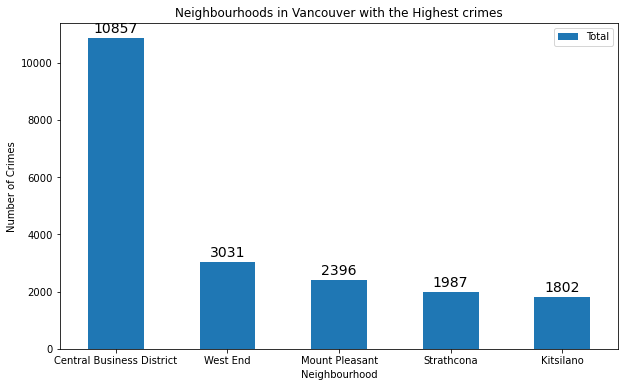

In [26]:
# Visualizing five neighborhoods with top crimes

import matplotlib.pyplot as plt

per_neigh = crime_neigh_top5[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

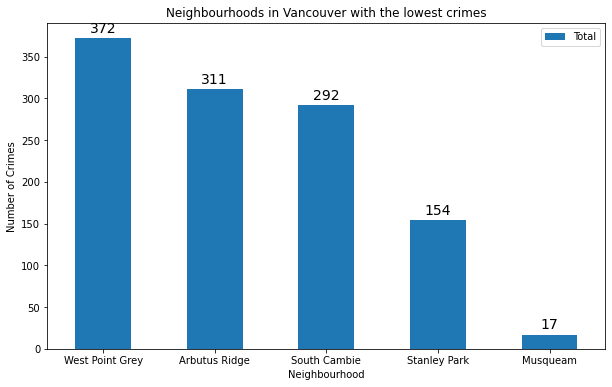

In [27]:
# visualizing 5 neighborhoods with low crimes

crime_neigh_low = vnc_crime_neigh.tail(5)
crime_neigh_low

per_neigh = crime_neigh_low[['Neighbourhood','Total']]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Vancouver with the lowest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

In [28]:
# Borough in Vancover city with highest crime

vnc_crime_cat = pd.pivot_table(vnc_boroughs_crime,
                               values=['Year'],
                               index=['Borough'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
vnc_crime_cat

Year                                    \
Type            Break and Enter Commercial Break and Enter Residential/Other   
Borough                                                                        
Central                                787                               198   
East Side                              786                              1043   
South Vancouver                         49                               156   
West Side                              403                              1000   
All                                   2025                              2397   

                                                                          \
Type            Mischief Other Theft Theft from Vehicle Theft of Bicycle   
Borough                                                                    
Central             2280        2489               6871              857   
East Side           2192        1674               4754              678   
South Vancouver      187          88                483               36   
West Side           1062         696               2838              588   
All                 5721        4947              14946             2159   

                                  \
Type            Theft of Vehicle   
Borough                            
Central                      245   
East Side                    605   
South Vancouver               71   
West Side                    225   
All                         1146   

                                                                        \
Type            Vehicle Collision or Pedestrian Struck (with Fatality)   
Borough                                                                  
Central                                                          1       
East Side                                                        8       
South Vancouver                                                  1       
West Side                                                        3       
All                                                             13       

                                                                             
Type            Vehicle Collision or Pedestrian Struck (with Injury)    All  
Borough                                                                      
Central                                                        314    14042  
East Side                                                      660    12400  
South Vancouver                                                111     1182  
West Side                                                      389     7204  
All                                                           1474    34828

In [29]:
vnc_crime_cat.reset_index(inplace = True)
vnc_crime_cat.columns = vnc_crime_cat.columns.map(''.join)
vnc_crime_cat.rename(columns={'YearAll':'Total',
                              'YearBreak and Enter Commercial' : 'Break and Enter Commercial',
                              'YearBreak and Enter Residential/Other' : 'Break and Enter Residential',
                              'YearMischief' : 'Mischief',
                              'YearOther Theft' : 'Other',
                              'YearTheft from Vehicle' : 'Theft from Vehicle',
                              'YearTheft of Bicycle' : 'Theft of Bicycle',
                              'YearTheft of Vehicle' : 'Theft of Vehicle',
                              'YearVehicle Collision or Pedestrian Struck (with Fatality)' : 'Vehicle Collision or Pedestrian Struck (with Fatality)',
                              'YearVehicle Collision or Pedestrian Struck (with Injury)' : 'Vehicle Collision or Pedestrian Struck (with Injury)'}, inplace=True)
# To ignore bottom All in Borough
vnc_crime_cat = vnc_crime_cat.head(4)
vnc_crime_cat

,Borough,Break and Enter Commercial,Break and Enter Residential,Mischief,Other,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury),Total
0,Central,787,198,2280,2489,6871,857,245,1,314,14042
1,East Side,786,1043,2192,1674,4754,678,605,8,660,12400
2,South Vancouver,49,156,187,88,483,36,71,1,111,1182
3,West Side,403,1000,1062,696,2838,588,225,3,389,7204


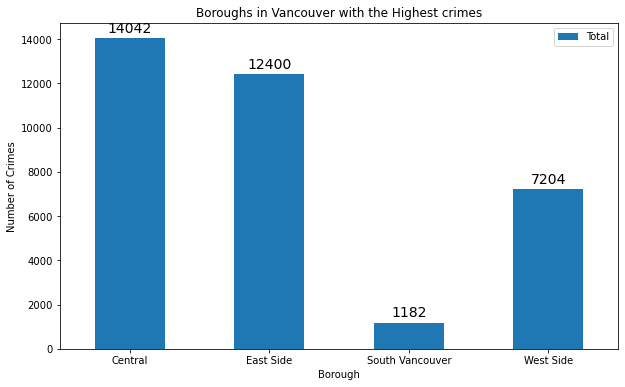

In [30]:
per_borough = vnc_crime_cat[['Borough','Total']]

per_borough.set_index('Borough',inplace = True)

ax = per_borough.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Boroughs in Vancouver with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

Based on exploratory data analysis it is clear that South Vancouver has the lowest crimes

Part 3: Creating a new consolidated dataset of the Neighborhoods, along with their boroughs, crime data and the respective Neighbourhood's co-ordinates:

This data will be fetched using OpenCage Geocoder to find the safest borough and explore the neighbourhood by plotting it on maps using Folium 
and perform exploratory data analysis.

In [31]:
vnc_ws_neigh = vnc_boroughs_crime

#vnc_ws_neigh.drop(['Type','Year', 'Month', 'Day', 'Hour'], axis = 1, inplace = True)
vnc_ws_neigh = vnc_ws_neigh[vnc_ws_neigh['Borough'] == 'West Side']
vnc_ws_neigh.reset_index(inplace=True, drop=True)

print('Number of Neighbourhoods in West Side Borough', len(vnc_ws_neigh['Neighbourhood'].unique()))

vnc_ws_neigh['Neighbourhood'].unique()

Number of Neighbourhoods in West Side Borough 10


array(['Shaughnessy', 'Fairview', 'Oakridge', 'Marpole', 'Kitsilano',
       'Kerrisdale', 'West Point Grey', 'Arbutus Ridge', 'South Cambie',
       'Dunbar-Southlands'], dtype=object)

Fetching the Geographical co-ordiantes of Vancouver to plot on Map using foursquare_agent

In [43]:
from geopy.geocoders import Nominatim


address = 'Vancouver, BC, Canada'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)



49.2608724 -123.1139529


Part 4: Creating a new consolidated dataset of the Neighborhoods, boroughs, and the most common venues and the respective Neighbourhood along with co-ordinates:

This data will be fetched using Four Square API to explore the neighbourhood venues and to apply machine learning algorithm to cluster the neighbourhoods 
and present the findings by plotting it on maps using Folium.


In [60]:
#Four Square Credentials

CLIENT_ID = 'RN2GGKUB2KT5RQDNK3VBYUI4GGTRXXAIRYMH1OSF4FQVG0CQ'
CLIENT_SECRET = '5XFMIUIDMVPKN43QQZBHULSDXEYPDDFXRXK10P21XZXVPKJY'
VERSION = '20201019'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RN2GGKUB2KT5RQDNK3VBYUI4GGTRXXAIRYMH1OSF4FQVG0CQ
CLIENT_SECRET:5XFMIUIDMVPKN43QQZBHULSDXEYPDDFXRXK10P21XZXVPKJY


In [ ]:
#defining the function ti get top 10 venues around a neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
# generating those venues
vnc_ws_venues = getNearbyVenues(names=ws_neig_geo['Neighbourhood'],
                                   latitudes=ws_neig_geo['Latitude'],
                                   longitudes=ws_neig_geo['Longitude']
                                  )

Modelling

In [ ]:
vnc_onehot = pd.get_dummies(vnc_ws_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vnc_onehot['Neighbourhood'] = vnc_ws_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [vnc_onehot.columns[-1]] + list(vnc_onehot.columns[:-1])
vnc_onehot = vnc_onehot[fixed_columns]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = vnc_ws_grouped['Neighbourhood']

for ind in np.arange(vnc_ws_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vnc_ws_grouped.iloc[ind, :], num_top_venues)


Cluster of neighborhoods

In [ ]:
# set number of clusters
kclusters = 5

vnc_grouped_clustering = vnc_ws_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vnc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

eighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_merged = ws_neig_geo

# merge toronto_grouped with Vancouver data to add latitude/longitude for each neighborhood
vancouver_merged = vancouver_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

vancouver_merged.head()


Creating map of clusters below

In [ ]:
# create map
import folium 
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_merged['Latitude'], vancouver_merged['Longitude'], vancouver_merged['Neighbourhood'], vancouver_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Results and Discussions are below:

The objective of the business problem was to help stakeholders identify one of the safest borough in Vancouver, and an appropriate neighborhood within the borough to set up a commercial establishment especially a Grocery store. This has been achieved by first making use of Vancouver crime data to identify a safe borugh with considerable number of neighborhood for any business to be viable. 

After selecting the borough it was imperative to choose the right neighborhood where grocery shops were not among venues in a close proximity to each other. We achieved this by grouping the neighborhoods into clusters to assist the stakeholders by providing them with relavent data about venues and safety of a given neighborhood.


# Conclusion is below :

We have explored the crime data to understand different types of crimes in all neighborhoods of Vancouver and later categorized them into different boroughs, 
this helped us group the neighborhoods into boroughs and choose the safest borough first. 

Once we confirmed the borough the number of neighborhoods for consideration also comes down, we further shortlist the neighborhoods based on the common venues, 
to choose a neighborhood which best suits the business problem.
